# <span style = 'color : orange'>Question 3 - A02</span>

## <span style = 'color:magenta'>CGAN Implementation</span>

In [1]:
import tensorflow as tf

## Data Preprocessing

In [18]:
import os
import tensorflow as tf

# Paths for sketches and real faces
sketches_path = 'C:\\Users\\Zunaira\\Documents\\7th Semester\\Gen AI\\Assignments\\A02\\test\\sketches'
real_faces_path = 'C:\\Users\\Zunaira\\Documents\\7th Semester\\Gen AI\\Assignments\\A02\\test\\photos'  # Update with actual path

# Function to load and preprocess images
def load_and_preprocess_image(filepath, size=(128, 128)):  # Resize to (128, 128)
    # Read and decode image
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)  # Decode with 3 color channels
    # Resize to target size
    image = tf.image.resize(image, size)  # This will downscale the image
    # Normalize pixel values to [-1, 1]
    image = (image / 127.5) - 1
    return image

# Load dataset function with sketch and face pairs
def load_dataset(sketches_dir, faces_dir):
    # Sort filenames to ensure correct pairing by index
    sketch_files = sorted([os.path.join(sketches_dir, fname) for fname in os.listdir(sketches_dir)])
    face_files = sorted([os.path.join(faces_dir, fname) for fname in os.listdir(faces_dir)])

    # Create TensorFlow dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((sketch_files, face_files))

    # Function to load paired images
    def load_pair(sketch_path, face_path):
        sketch_image = load_and_preprocess_image(sketch_path)
        face_image = load_and_preprocess_image(face_path)
        return sketch_image, face_image

    # Apply loading and preprocessing function
    dataset = dataset.map(load_pair, num_parallel_calls=tf.data.AUTOTUNE)
    # Batch and prefetch for efficient training
    return dataset.batch(8).prefetch(tf.data.AUTOTUNE)  # Adjust batch size as needed

# Initialize the dataset
dataset = load_dataset(sketches_path, real_faces_path)


## Generator

In [4]:
import tensorflow as tf

class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()

        # Encoder (Downsampling layers)
        self.encoder_layers = [
            tf.keras.layers.Conv2D(64, (4, 4), strides=2, padding='same'), # 256x256x64
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(128, (4, 4), strides=2, padding='same'), # 128x128x128
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(256, (4, 4), strides=2, padding='same'), # 64x64x256
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(512, (4, 4), strides=2, padding='same'), # 32x32x512
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(512, (4, 4), strides=2, padding='same'), # 16x16x512
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(512, (4, 4), strides=2, padding='same'), # 8x8x512
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
        ]

        # Decoder (Upsampling layers)
        self.decoder_layers = [
            tf.keras.layers.Conv2DTranspose(512, (4, 4), strides=2, padding='same'), # 16x16x512
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(512, (4, 4), strides=2, padding='same'), # 32x32x512
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(256, (4, 4), strides=2, padding='same'), # 64x64x256
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same'), # 128x128x128
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same'), # 256x256x64
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(3, (4, 4), strides=2, padding='same', activation='tanh') # 512x512x3
        ]

    def call(self, inputs):
        # Pass input through each encoder layer
        x = inputs
        for layer in self.encoder_layers:
            x = layer(x)

        # Pass through each decoder layer
        for layer in self.decoder_layers:
            x = layer(x)

        return x

# Instantiate the generator
generator = Generator()


## Discriminator 

In [ ]:
import tensorflow as tf

class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Discriminator layers
        self.model_layers = [
            # First convolutional block
            tf.keras.layers.Conv2D(64, (4, 4), strides=2, padding='same', input_shape=(128, 128, 3)), # 256x256x64
            tf.keras.layers.LeakyReLU(alpha=0.2),

            # Second convolutional block
            tf.keras.layers.Conv2D(128, (4, 4), strides=2, padding='same'), # 128x128x128
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.2),

            # Third convolutional block
            tf.keras.layers.Conv2D(256, (4, 4), strides=2, padding='same'), # 64x64x256
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.2),

            # Fourth convolutional block
            tf.keras.layers.Conv2D(512, (4, 4), strides=2, padding='same'), # 32x32x512
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.2),

            # Fifth convolutional block
            tf.keras.layers.Conv2D(512, (4, 4), strides=2, padding='same'), # 16x16x512
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.2),

            # Output layer
            tf.keras.layers.Conv2D(1, (4, 4), strides=1, padding='same', activation='sigmoid') # 16x16x1
        ]

    def call(self, inputs):
        # Pass input through each layer
        x = inputs
        for layer in self.model_layers:
            x = layer(x)

        return x

# Instantiate the discriminator
discriminator = Discriminator()

# Function to concatenate sketch and face image pairs
def create_discriminator_input(sketch, face):
    # Concatenate along the channel dimension
    return tf.concat([sketch, face], axis=-1)


## Calculating Loss

In [6]:
import tensorflow as tf

# Binary Cross-Entropy for both generator and discriminator
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Generator Loss
def generator_loss(fake_output, generated_image, target_image, lambda_mse=100):
    # Adversarial loss: penalizes the generator if the discriminator correctly identifies the generated image as fake
    adv_loss = bce(tf.ones_like(fake_output), fake_output)

    # Pixel-wise loss (MSE) between generated and real target images for visual fidelity
    mse_loss = tf.reduce_mean(tf.square(generated_image - target_image))

    # Total generator loss
    total_gen_loss = adv_loss + lambda_mse * mse_loss
    return total_gen_loss

# Discriminator Loss
def discriminator_loss(real_output, fake_output):
    # Real pairs should be classified as 1 (real)
    real_loss = bce(tf.ones_like(real_output), real_output)

    # Fake pairs should be classified as 0 (fake)
    fake_loss = bce(tf.zeros_like(fake_output), fake_output)

    # Total discriminator loss
    total_disc_loss = real_loss + fake_loss
    return total_disc_loss


## Applying Optimizer and Training

In [24]:
import tensorflow as tf
from tqdm import tqdm

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

# Training step function with batch processing and adversarial training
@tf.function
def train_step(sketches, real_images):
    # Begin the forward pass and gradient calculations for the generator and discriminator
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images from the sketches
        generated_images = generator(sketches, training=True)

        # Discriminator output for real and generated images
        real_output = discriminator(tf.concat([sketches, real_images], axis=-1), training=True)
        fake_output = discriminator(tf.concat([sketches, generated_images], axis=-1), training=True)

        # Calculate generator and discriminator losses
        gen_loss = generator_loss(fake_output, generated_images, real_images)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Compute and apply gradients to update the generator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    # Compute and apply gradients to update the discriminator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Full training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        print(f'Starting Epoch {epoch + 1}/{epochs}')
        gen_loss_avg = tf.keras.metrics.Mean()
        disc_loss_avg = tf.keras.metrics.Mean()

        # Process batches for adversarial training
        for sketches, real_images in tqdm(dataset):
            # Perform a training step
            gen_loss, disc_loss = train_step(sketches, real_images)
            gen_loss_avg.update_state(gen_loss)
            disc_loss_avg.update_state(disc_loss)

        # Log generator and discriminator loss values at the end of each epoch
        print(f"Epoch {epoch + 1} - Generator Loss: {gen_loss_avg.result():.4f}, Discriminator Loss: {disc_loss_avg.result():.4f}")

        # Optionally, visualize generated images for progress monitoring


# Function to prepare the dataset
def prepare_dataset(sketch_paths, face_paths, batch_size=16):
    sketch_files = [os.path.join(sketch_paths, f) for f in os.listdir(sketch_paths) if f.endswith('.jpg') or f.endswith('.png')]
    face_files = [os.path.join(face_paths, f) for f in os.listdir(face_paths) if f.endswith('.jpg') or f.endswith('.png')]
    
    sketches = [load_and_preprocess_image(file) for file in sketch_files]
    faces = [load_and_preprocess_image(file) for file in face_files]
    
    dataset = tf.data.Dataset.from_tensor_slices((sketches, faces))
    dataset = dataset.batch(batch_size)
    
    return dataset

sketch_paths = r'C:\Users\Zunaira\Documents\7th Semester\Gen AI\Assignments\A02\test\sketches'
face_paths = r'C:\Users\Zunaira\Documents\7th Semester\Gen AI\Assignments\A02\test\photos'
# 
# dataset and start training
dataset = prepare_dataset(sketch_paths, face_paths,batch_size=8)



train(dataset, epochs=35)




Starting Epoch 1/35


  0%|          | 0/85 [00:00<?, ?it/s]C:\Users\Zunaira\AppData\Roaming\Python\Python310\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
100%|██████████| 85/85 [02:04<00:00,  1.46s/it]


Epoch 1 - Generator Loss: 30.1917, Discriminator Loss: 0.6828
Starting Epoch 2/35


100%|██████████| 85/85 [01:45<00:00,  1.24s/it]


Epoch 2 - Generator Loss: 24.2112, Discriminator Loss: 0.5542
Starting Epoch 3/35


100%|██████████| 85/85 [01:48<00:00,  1.27s/it]


Epoch 3 - Generator Loss: 21.8104, Discriminator Loss: 0.6264
Starting Epoch 4/35


100%|██████████| 85/85 [01:46<00:00,  1.25s/it]


Epoch 4 - Generator Loss: 19.0439, Discriminator Loss: 0.6136
Starting Epoch 5/35


100%|██████████| 85/85 [02:01<00:00,  1.43s/it]


Epoch 5 - Generator Loss: 17.5671, Discriminator Loss: 0.6983
Starting Epoch 6/35


100%|██████████| 85/85 [01:45<00:00,  1.24s/it]


Epoch 6 - Generator Loss: 16.2741, Discriminator Loss: 0.7158
Starting Epoch 7/35


100%|██████████| 85/85 [01:53<00:00,  1.34s/it]


Epoch 7 - Generator Loss: 15.2148, Discriminator Loss: 0.7086
Starting Epoch 8/35


100%|██████████| 85/85 [01:49<00:00,  1.29s/it]


Epoch 8 - Generator Loss: 14.2277, Discriminator Loss: 0.7900
Starting Epoch 9/35


100%|██████████| 85/85 [01:52<00:00,  1.32s/it]


Epoch 9 - Generator Loss: 13.5986, Discriminator Loss: 0.7874
Starting Epoch 10/35


100%|██████████| 85/85 [01:51<00:00,  1.31s/it]


Epoch 10 - Generator Loss: 12.8842, Discriminator Loss: 0.8184
Starting Epoch 11/35


100%|██████████| 85/85 [02:15<00:00,  1.59s/it]


Epoch 11 - Generator Loss: 11.9399, Discriminator Loss: 0.8981
Starting Epoch 12/35


100%|██████████| 85/85 [02:02<00:00,  1.45s/it]


Epoch 12 - Generator Loss: 11.3638, Discriminator Loss: 0.9011
Starting Epoch 13/35


100%|██████████| 85/85 [01:54<00:00,  1.35s/it]


Epoch 13 - Generator Loss: 10.6924, Discriminator Loss: 0.8685
Starting Epoch 14/35


100%|██████████| 85/85 [01:51<00:00,  1.32s/it]


Epoch 14 - Generator Loss: 10.1121, Discriminator Loss: 0.9209
Starting Epoch 15/35


100%|██████████| 85/85 [01:51<00:00,  1.31s/it]


Epoch 15 - Generator Loss: 9.6944, Discriminator Loss: 0.8884
Starting Epoch 16/35


100%|██████████| 85/85 [01:49<00:00,  1.29s/it]


Epoch 16 - Generator Loss: 9.3329, Discriminator Loss: 0.9565
Starting Epoch 17/35


100%|██████████| 85/85 [01:54<00:00,  1.35s/it]


Epoch 17 - Generator Loss: 8.8854, Discriminator Loss: 0.9160
Starting Epoch 18/35


100%|██████████| 85/85 [01:46<00:00,  1.25s/it]


Epoch 18 - Generator Loss: 8.4588, Discriminator Loss: 0.9268
Starting Epoch 19/35


100%|██████████| 85/85 [01:51<00:00,  1.31s/it]


Epoch 19 - Generator Loss: 8.0747, Discriminator Loss: 0.9400
Starting Epoch 20/35


100%|██████████| 85/85 [01:57<00:00,  1.39s/it]


Epoch 20 - Generator Loss: 7.7509, Discriminator Loss: 0.9627
Starting Epoch 21/35


100%|██████████| 85/85 [01:49<00:00,  1.29s/it]


Epoch 21 - Generator Loss: 7.4279, Discriminator Loss: 0.9959
Starting Epoch 22/35


100%|██████████| 85/85 [01:48<00:00,  1.28s/it]


Epoch 22 - Generator Loss: 7.1774, Discriminator Loss: 1.0140
Starting Epoch 23/35


100%|██████████| 85/85 [01:48<00:00,  1.28s/it]


Epoch 23 - Generator Loss: 6.6841, Discriminator Loss: 1.0243
Starting Epoch 24/35


100%|██████████| 85/85 [01:49<00:00,  1.29s/it]


Epoch 24 - Generator Loss: 6.4285, Discriminator Loss: 1.0121
Starting Epoch 25/35


100%|██████████| 85/85 [01:48<00:00,  1.28s/it]


Epoch 25 - Generator Loss: 6.2457, Discriminator Loss: 0.9962
Starting Epoch 26/35


100%|██████████| 85/85 [01:47<00:00,  1.26s/it]


Epoch 26 - Generator Loss: 6.1218, Discriminator Loss: 1.0246
Starting Epoch 27/35


100%|██████████| 85/85 [01:44<00:00,  1.23s/it]


Epoch 27 - Generator Loss: 5.8565, Discriminator Loss: 1.0234
Starting Epoch 28/35


100%|██████████| 85/85 [01:54<00:00,  1.35s/it]


Epoch 28 - Generator Loss: 5.7265, Discriminator Loss: 1.0080
Starting Epoch 29/35


100%|██████████| 85/85 [02:07<00:00,  1.50s/it]


Epoch 29 - Generator Loss: 5.6133, Discriminator Loss: 1.0406
Starting Epoch 30/35


100%|██████████| 85/85 [02:14<00:00,  1.58s/it]


Epoch 30 - Generator Loss: 5.3103, Discriminator Loss: 1.0427
Starting Epoch 31/35


100%|██████████| 85/85 [02:24<00:00,  1.69s/it]


Epoch 31 - Generator Loss: 5.0914, Discriminator Loss: 1.0561
Starting Epoch 32/35


100%|██████████| 85/85 [02:12<00:00,  1.56s/it]


Epoch 32 - Generator Loss: 4.8454, Discriminator Loss: 1.0663
Starting Epoch 33/35


100%|██████████| 85/85 [02:11<00:00,  1.55s/it]


Epoch 33 - Generator Loss: 4.8080, Discriminator Loss: 1.0103
Starting Epoch 34/35


100%|██████████| 85/85 [02:09<00:00,  1.53s/it]


Epoch 34 - Generator Loss: 4.7470, Discriminator Loss: 1.0972
Starting Epoch 35/35


100%|██████████| 85/85 [02:09<00:00,  1.52s/it]

Epoch 35 - Generator Loss: 4.5542, Discriminator Loss: 1.0887


## Save Model

In [79]:
# Save the generator model
generator.save('./Q3_model', save_format='tf')

# Save the discriminator model
discriminator.save('./Q3_model', save_format='tf')


INFO:tensorflow:Assets written to: ./Q3_model\assets


INFO:tensorflow:Assets written to: ./Q3_model\assets


INFO:tensorflow:Assets written to: ./Q3_model\assets


INFO:tensorflow:Assets written to: ./Q3_model\assets


## Loading Model 

In [80]:
from tensorflow.keras.models import load_model

# Load the generator model
loaded_generator = load_model('./Q3_model')

# Load the discriminator model
loaded_discriminator = load_model('./Q3_model')


In [ ]:
# Assuming `sketch` is your input tensor
generated_image = loaded_generator(sketch, training=False)

# Post-processing (if needed)
generated_image = (generated_image[0] + 1) / 2.0  # Scale back to [0, 1]


## Model Summary 

In [62]:
generator.summary()  # Check the input shape of your generator


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           multiple                  6208      
                                                                 
 leaky_re_lu (LeakyReLU)     multiple                  0         
                                                                 
 conv2d_7 (Conv2D)           multiple                  131200    
                                                                 
 batch_normalization_11 (Bat  multiple                 512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   multiple                  0         
                                                                 
 conv2d_8 (Conv2D)           multiple                  524544    
                                                     

In [63]:
generator_input = tf.keras.layers.Input(shape=(128, 128, 6))  # Generator input shape


In [64]:
import numpy as np

# Create a dummy input for testing
dummy_input_sketches = np.random.rand(1, 128, 128, 6).astype(np.float32)  # Shape: (1, 128, 128, 6)

# Generate a face from the dummy sketch
generated_face = generator(dummy_input_sketches)

# Ensure the output shape is what you expect
print(f"Generated face shape: {generated_face.shape}")  # Should match your target output shape


Generated face shape: (1, 4, 4, 1)


In [69]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def load_and_preprocess_image(path):
    # Assuming you have a function to load and preprocess images
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [512, 512])  # Resize to your model's input size
    image = (image / 255.0) * 2 - 1  # Normalize to [-1, 1]
    return image

# Load new sketches for testing
new_sketch_paths = [
    # Add paths to your new sketches here
    r'C:\Users\Zunaira\Documents\7th Semester\Gen AI\Assignments\A02\test\sketches\423.jpg',
    r'C:\Users\Zunaira\Documents\7th Semester\Gen AI\Assignments\A02\test\sketches\505.jpg',
]
new_sketches = [load_and_preprocess_image(path) for path in new_sketch_paths]

# Convert to a tensor and add batch dimension
new_sketches_tensor = tf.convert_to_tensor(new_sketches)
new_sketches_tensor = tf.expand_dims(new_sketches_tensor, axis=0)  # Add batch dimension


## Sketch to Face

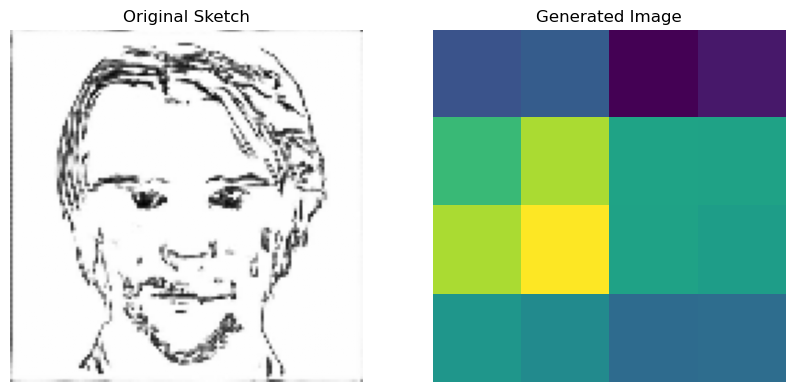

In [76]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the trained generator model
generator = tf.keras.models.load_model('./Q3_model')

# Function to load and preprocess a sketch image
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])  # Resize to 128x128
    image = (image / 127.5) - 1  # Scale images to [-1, 1]
    return image

# Load and preprocess the sketch
sketch_path = r'C:\Users\Zunaira\Documents\7th Semester\Gen AI\Assignments\A02\test\sketches\505.jpg'
sketch = load_and_preprocess_image(sketch_path)

# If your model expects an additional input, you may need to create a dummy input or concatenate
# Here, I'm just expanding dimensions to (1, 128, 128, 3)
sketch = tf.expand_dims(sketch, axis=0)  # Shape: (1, 128, 128, 3)

# If your model expects 6 channels, you could repeat the sketch 2 times to create 6 channels
# This is just a guess, please adjust based on your model requirements
sketch = tf.concat([sketch, sketch], axis=-1)  # Shape: (1, 128, 128, 6)

# Generate the image from the sketch
generated_image = generator(sketch, training=False)

# Remove batch dimension for visualization
generated_image = (generated_image[0] + 1) / 2.0  # Scale back to [0, 1]

# Display the original sketch and the generated image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Sketch")
plt.imshow((sketch[0, :, :, :3] + 1) / 2.0)  # Scale back to [0, 1]
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Generated Image")
plt.imshow(generated_image)
plt.axis('off')

plt.show()


## Face to Sketch

In [77]:
import cv2

def convert_to_sketch(image_path, output_path):
    # Read the image
    img = cv2.imread(image_path)

    # Convert to gray scale
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Invert the gray image
    inverted_image = 255 - gray_image

    # Blur the inverted image
    blurred_image = cv2.GaussianBlur(inverted_image, (21, 21), sigmaX=0, sigmaY=0)

    # Invert the blurred image
    inverted_blurred = 255 - blurred_image

    # Create the sketch image
    sketch = cv2.divide(gray_image, inverted_blurred, scale=256.0)

    # Save the sketch
    cv2.imwrite(output_path, sketch)

# Usage
convert_to_sketch('C:\\Users\\Zunaira\\Documents\\7th Semester\\Gen AI\\Assignments\\A02\\test\\photos\\828.jpg', 'output_sketch.png')



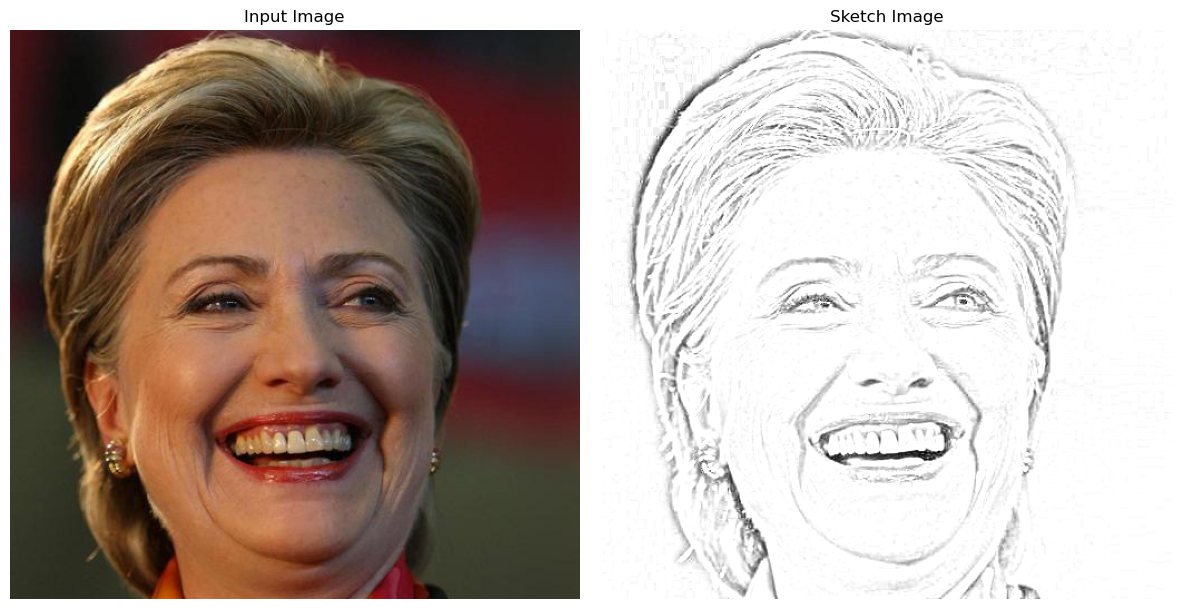

In [78]:
import matplotlib.pyplot as plt
import cv2

# Load the original image
input_image_path = 'C:\\Users\\Zunaira\\Documents\\7th Semester\\Gen AI\\Assignments\\A02\\test\\photos\\828.jpg'  # Update with your input image path
input_image = cv2.imread(input_image_path)

# Load the sketch image
sketch_image_path = './output_sketch.png'   # Update with your sketch image path
sketch_image = cv2.imread(sketch_image_path, cv2.IMREAD_GRAYSCALE)

# Create a figure to display the images
plt.figure(figsize=(12, 6))

# Display the input image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
plt.axis('off')  # Hide axis
plt.title('Input Image')

# Display the sketch image
plt.subplot(1, 2, 2)
plt.imshow(sketch_image, cmap='gray')
plt.axis('off')  # Hide axis
plt.title('Sketch Image')

# Show the figure
plt.tight_layout()
plt.show()
